### Acceptance Loop and Sampling Bias

The sampling bias is created through the so called Acceptance Loop. Since we are unable to know the true label of a rejected credit application, we are left with no other option, than to train our model on data points that itself once accepted. This is creating a loop, which is marked red in the following graph.

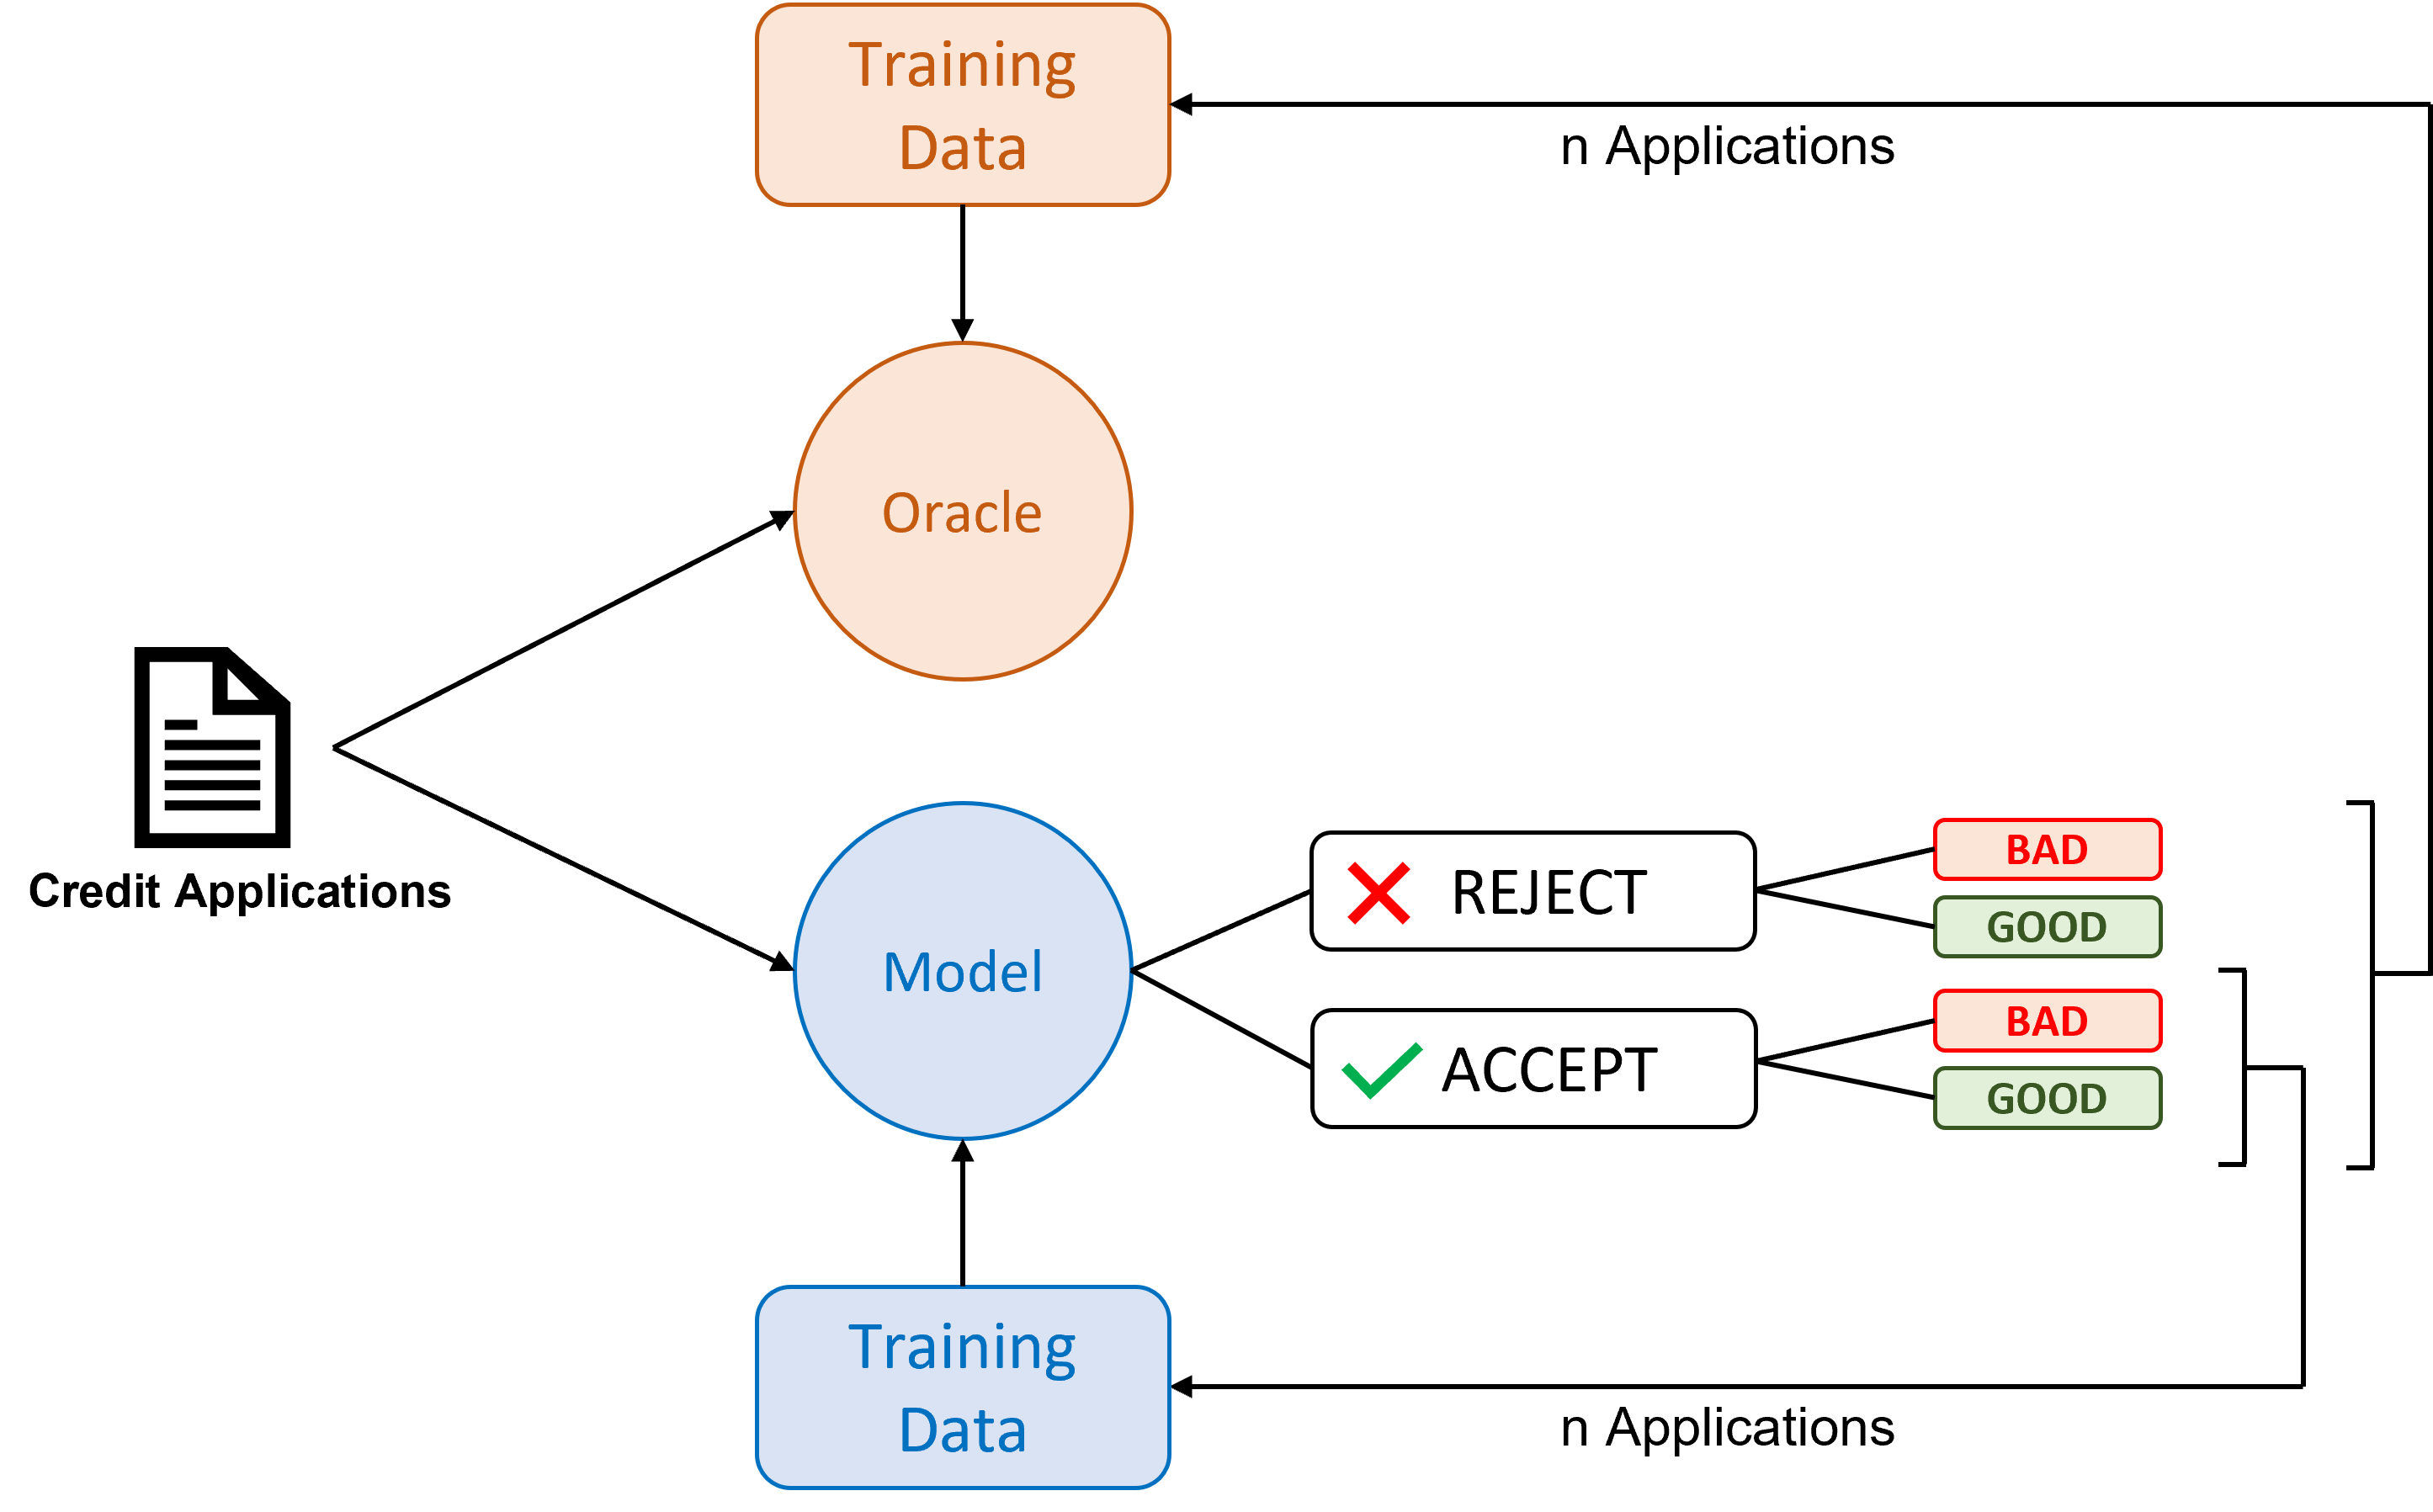

In order to test any sampling bias minimizing reject inference methods, we need to measure the baseline sampling bias. This can be done fairly easily by simulating the above-described process of rating loan applications and iteratively retrain the rating model on additional cases it accepted in the previously. To then be able to measure the bias we can compare the performance of the credit scoring model over time to a second model, we call oracle, that was retrained on additional accepted and rejected cases in each iteration. This oracle model is not possible in the real world but serves as a theoretically possible baseline for our tests, incorporating all the available information that we try to recover with our reject inference methods.

We have developed a dedicated class, handling our credit scoring simulations. It allows for various different experimental setups and keeps track of a variety of metrics to evaluate and compare results. In the following section we will describe critical code blocks of that class in the notebook, but to be useful this class is of course contained in a separate py file that is imported when we test our autoencoder.

Let us first have a look at the constructor for that class, that handles all the data loading and preparation for the subsequent simulation and thus already receives a lot of parameters.

In [ ]:
class Simulate_acceptance_loop():

    def __init__(self, dataset_name: str, model, model_fit_split: float, holdout_test_split: float, n_loops: int, enc_features: bool = False, encoder: aenc.Autoencoder = None, rej_inf = None, incl_rejected: bool = False):
        self.n_loops = n_loops
        self.rej_inf = rej_inf

        # custom Transformer, that standard scales and then encodes the data with Autoencoder "encoder"
        def std_enco(x):
            x_np = x.values.reshape(-1, x.shape[1]).astype('float32')
            x_trans = pre.StandardScaler().fit_transform(x_np)
            with torch.no_grad():
                x_encoded = encoder.encode(torch.from_numpy(x_trans)).numpy()
            return x_encoded

        # Either normal StandardScaler or StandardScaler and Encoder
        if enc_features:
            self.transformer  =  pre.FunctionTransformer(std_enco)
        else:
            self.transformer  = pre.StandardScaler()

>We will explore all the constructors’ parameters as we progress in the code. In the very first part of the initialization we make the most important decision for the subsequent simulation: whether we want to run it on the original (standard scaled, however) or on the encoded features. If _enc_features_ is set to true, we must provide a trained `Autoencoder` _encoder_ as a parameter, that will encode data via a custom sklearn FunctionTransformer. Of course before the data is encoded it is also standard scaled.
>
>The class allows for an optional parameter _rej_inf_, that must be a function that trains a model. This allows for some alternative, simpler reject inference methods, that rely on training models with specially weighted datapoints to fight sampling bias.

In [ ]:
        # load dataset
        complete_data = pd.read_csv(f'../prepared_data/{dataset_name}', sep=',')
        complete_data['BAD'] = np.where(complete_data['BAD'] == 'BAD', 1, 0).astype(np.int64)

        obj_cols = complete_data.select_dtypes('object').columns
        complete_data[obj_cols] = complete_data[obj_cols].astype('category')

        # For the sake of simplicity when dealing with neural nets later, let's just make everything categorical continous
        for col in obj_cols:
            woe_calc = h.IV_Calc(complete_data, feature=col, target='BAD')
            woe = woe_calc.full_summary()['WOE_adj'].to_dict()
            complete_data[col] = complete_data[col].map(woe)
            complete_data[col] = complete_data[col].astype('float64')

        complete_X = complete_data.iloc[:, complete_data.columns != 'BAD']
        complete_y = complete_data['BAD']

>Another important aspect follows, after the data is loaded by datasetname from the prepared_data folder. In oder to make things a lot easier when testing different models and more importantly when handling the Autoencoder, we transform every non-numerical feature to be represented in terms of `Weight of Evidence`. We then split our features from the target.

In [ ]:
        # get part of the data for inital model fitting
        X_remaining, X_model_fit, y_remaining, y_model_fit = train_test_split(complete_X, complete_y, test_size=model_fit_split, stratify=complete_y, random_state=123)

        # reserve holdout data for model evaluation
        X_simulation, X_holdout, y_simulation, y_holdout = train_test_split(X_remaining, y_remaining, test_size=holdout_test_split, stratify=y_remaining, random_state=123)

        self.holdout_test_X = X_holdout
        self.holdout_test_y = y_holdout

        # put simulation data back together
        self.simulation_data = pd.concat([X_simulation, y_simulation], axis=1)

        # initial fit of model and oracle model on remaining data
        self.model = model
        self.oracle = clone(model)

        self.transformer.fit(X_model_fit)
        X_model_fit_trans = self.transformer.transform(X_model_fit)
        self.model.fit(X_model_fit_trans, y_model_fit)

        self.oracle.fit(X_model_fit_trans, y_model_fit)

        # store all available train data
        self.all_train_X = X_model_fit
        self.all_train_y = y_model_fit

        self.oracle_all_train_X = X_model_fit
        self.oracle_all_train_y = y_model_fit

>We then define to splits in the data. The first split, governed by the variable _model_fit_split_, removes a first fraction of the loaded data set and puts it aside to train our initial model. We need this part of the data, because a trained model is already required in the first iteration of our simulation to accept and reject applications. The parameter that determines the size of that initial split has an important impact on the obeservable sampling bias as we will see below.
>
>The second split, specified by _holdout_test_split_, takes away another fraction of the remaining data, this time to be used as a consistent test set to evaluate model performances during the simulation.
>
>We then transform the data of the initial model fitting, so either just standard scale it or encode it using a trained autoencoder, and fit the model initially. Important to notice is that we create an exact copy of the supplied model, _oracle_, that we initially fit with the same data. This oracle model copy will be actively hindered to run into the acceptance loop, to have a theoretical upper bound for model performance without any sampling bias.
>
>For the subsequent simulation we have to keep track of all the available training data throughout each iteration, which is done in the _all_train_ attributes of the class.
>
>The class has only one methode, _run_, which is an iterator that yields some information and metrics after each iteration of our simulation. Having the simulation take place in an iterator makes it a lot easier to deal with large amounts of data, which we later will.

In [ ]:
    def run(self, accpet_fraction = 0.3):

        self.simulation_data = self.simulation_data.sample(frac=1, random_state=123)
        self.data_splits = np.array_split(self.simulation_data, self.n_loops)

        metrics = {"model": {"rolling": {"roc_auc": [], "accuracy": [], "f1": [], "precision": []},
                    "holdout": {"roc_auc": [], "accuracy": [], "f1": [], "precision": []}},
                "oracle": {"rolling": {"roc_auc": [], "accuracy": [], "f1": [], "precision": []},
                    "holdout": {"roc_auc": [], "accuracy": [], "f1": [], "precision": []}}}

>First, the remaining simulation data is shuffled and split up into _n_loops_, coresponding to the number of iterations we wish to simulate. Secondly, we define a dictionary that will keep track of a bunch of metrics we will evaluate during each simulation iteration. The simulation itself is essentially the following for loop.

In [ ]:
        for year in range(self.n_loops):
            # 1. get the new data for that year
            new_data = self.data_splits[year].reset_index(drop=True)
            X = new_data.iloc[:, new_data.columns != 'BAD']
            y = new_data['BAD']
            
            # 2. predict data for this year with model and oracle
            predicted_proba = self.model.predict_proba(self.transformer.transform(X))[:, 1]
            predicted_proba_oracle = self.oracle.predict_proba(self.transformer.transform(X))[:, 1]

            threshold = sorted(predicted_proba)[floor(len(predicted_proba)*accpet_fraction)] # accept top n% of aplicants
            if threshold == 0.0: threshold = 0.0001 # needed to allow for pure Tree Classifier Leafs

            predicted_abs = np.where(predicted_proba < threshold, 0, 1)
            predicted_abs_oracle = np.where(predicted_proba_oracle < 0.5, 0, 1)

            # 3. add accepted data points to all available training data
            accepted = [True if x == 0 else False for x in predicted_abs]
            
            self.all_train_X = pd.concat([self.all_train_X, X[accepted]], ignore_index=True)
            self.all_train_y = pd.concat([self.all_train_y, y[accepted]], ignore_index=True)

            # 3.2 add same number of points (but random points - so no acceptance bias) to oracle model
            random.shuffle(accepted)
            self.oracle_all_train_X = pd.concat([self.oracle_all_train_X, X[accepted]], ignore_index=True)
            self.oracle_all_train_y = pd.concat([self.oracle_all_train_y, y[accepted]], ignore_index=True)

            # verbose
            # print(f'Itteration: {year}) Accepted: {accepted.count(True)} | Denied: {accepted.count(False)} - New train set size: {self.all_train_X.shape}')

>It can be considered in two seperate steps. The first part of each iteration, or _years_, prepares the according chunk of 'fresh' data for that iteration, representing this years new applicants. We use our latest available model and oracle, stored in the respective class attributes, to predict whether an applicant will default or not. To deal with the commonly heavy imbalance in credit risk data sets, we determine a variable threshhold as a cut off probability to assign absolute values to the applications. (1 = BAD, meaning we will not accept that application, 0 = GOOD, meaning this application will be accepted and we can therefor observe its true label) This way we allways accept roughly the same amount of applicants in each iteration and can influence this amount. The amount of good applicants we accept is actually an important business decision that would need to be fine tuned along a cost matrix, considering opportunity costs and risks, etc. This was outside the scope of our project and we set up the loop to accept the top 30% of applications each year by default, which seemed to work well for us.
>
>We then update the models available tarining data by adding all the applicants it has just accpeted with their _true_, _observed_ labels. On the other hand, we update the oracles available training data by adding the same amount of randomly selected accpeted and rejected cases of the current iteration. Again also with the _true_ labels, that we can in this case only know in this experimental setup. Thus the name `Oracle`, as it magically knows the true labels of applications that were never granted the loan.

In [ ]:
            predicted_abs = np.where(predicted_proba < 0.5, 0, 1)

            # 4.1 save rolling_metrics for data of that year
            metrics["model"]["rolling"]['roc_auc'].append(roc_auc_score(y, predicted_proba))
            metrics["model"]["rolling"]['accuracy'].append(accuracy_score(y, predicted_abs))
            metrics["model"]["rolling"]['f1'].append(f1_score(y, predicted_abs))
            metrics["model"]["rolling"]['precision'].append(precision_score(y, predicted_abs))

            metrics["oracle"]["rolling"]['roc_auc'].append(roc_auc_score(y, predicted_proba_oracle))
            metrics["oracle"]["rolling"]['accuracy'].append(accuracy_score(y, predicted_abs_oracle))
            metrics["oracle"]["rolling"]['f1'].append(f1_score(y, predicted_abs_oracle))
            metrics["oracle"]["rolling"]['precision'].append(precision_score(y, predicted_abs_oracle))

            # 4.2 save metrics on evaluation hold out
            predicted_proba = self.model.predict_proba(self.transformer.transform(self.holdout_test_X))[:, 1]
            predicted_abs = np.where(predicted_proba < 0.5, 0, 1)

            predicted_proba_oracle = self.oracle.predict_proba(self.transformer.transform(self.holdout_test_X))[:, 1]
            predicted_abs_oracle = np.where(predicted_proba_oracle < 0.5, 0, 1)

            metrics["model"]["holdout"]['roc_auc'].append(roc_auc_score(self.holdout_test_y, predicted_proba))
            metrics["model"]["holdout"]['accuracy'].append(accuracy_score(self.holdout_test_y, predicted_abs))
            metrics["model"]["holdout"]['f1'].append(f1_score(self.holdout_test_y, predicted_abs))
            metrics["model"]["holdout"]['precision'].append(precision_score(self.holdout_test_y, predicted_abs))

            metrics["oracle"]["holdout"]['roc_auc'].append(roc_auc_score(self.holdout_test_y, predicted_proba_oracle))
            metrics["oracle"]["holdout"]['accuracy'].append(accuracy_score(self.holdout_test_y, predicted_abs_oracle))
            metrics["oracle"]["holdout"]['f1'].append(f1_score(self.holdout_test_y, predicted_abs_oracle))
            metrics["oracle"]["holdout"]['precision'].append(precision_score(self.holdout_test_y, predicted_abs_oracle))

            # 5. train model on all available data to improve
            self.transformer.fit(self.all_train_X)
            all_train_X_trans = self.transformer.transform(self.all_train_X)

            self.transformer.fit(self.oracle_all_train_X)
            oracle_all_train_X_trans = self.transformer.transform(self.oracle_all_train_X)
            
            if(self.rej_inf is None):
                self.model.fit(all_train_X_trans, self.all_train_y)
            else:
                self.rej_inf(self.model,all_train_X_trans, self.all_train_y)
                
            self.oracle.fit(oracle_all_train_X_trans, self.oracle_all_train_y)

            yield year, accepted, all_train_X_trans.shape, metrics

        return metrics

>In the second part of each iteration we then evaluate the current models. We do this on the current split of data for that iteration, but more importantly on the predefined holdout set. All the metrics are saved in the _metrics_ dictionary that is yielded after every iteration.
>
>After that, we retrain the model on the new additional data that was gathered in that iterartion. Before that we of course standard scale and or encode the data. If specified the _rej_inf_ function is used to train the model.
>
>This concludes one iteration and our dynamic acceptance loop simulation, which we use to "create" measurable sampling bias to check our autoencoder against.